# PINN-MPC:

This notebook implements the **PINN-MPC** framework, presented in: *"An Explicit Model Predictive Control Framework Based On Physics-Informed Neural Networks"* by Kardamaki et al., for a multi-input-multi-output (MIMO) quadruple nonlinear water tank system. The controller is trained as a feedforward neural network using a composite loss function that enforces the governing differential equations while incorporating control-oriented objectives such as set-point tracking, control smoothness, and soft constraints on states, inputs, and outputs.

This notebook is organized into sections for:
- Training the PINN-MPC using the composite loss function,
- Validating its performance on set-point tracking and disturbance rejection scenarios and inspecting plot results for closed-loop performance

All training hyperparameters, including the weights of the loss function and the settings of the optimizers, along with simulation parameters can be customized to explore different control configurations.


**Case Study Description:**

The process consists of two pairs of interconnected tanks arranged in lower and upper levels.

Each lower tank receives inflow through a controllable valve, while a fixed portion of this inflow is diverted to the corresponding upper tank according to split ratios $\gamma_1$ and $\gamma_2$. Similar to the single-tank case, measured disturbances $d_1(t)$ and $d_2(t)$ are modeled as additive inflow perturbations acting on the $u_1$ and $u_2$ paths, respectively. The upper tanks drain into the lower ones through gravity, introducing nonlinear coupling and cross-interactions among all four states. The time evolution of the water levels is described by the nonlinear dynamic system below:


$$ \dot{x_1}(t) = \frac{1}{A_1}\!\left(\gamma_1\,\big(u_1(t){+}d_1(t)\big)\;+\;K_3\,\sqrt{x_3(t)}\;-\;K_1\,\sqrt{x_1(t)}\right) $$
$$ \dot{x_2}(t) = \frac{1}{A_2}\!\left(\gamma_2\,\big(u_2(t){+}d_2(t)\big)\;+\;K_4\,\sqrt{x_4(t)}\;-\;K_2\,\sqrt{x_2(t)}\right),$$
$$ \dot{x_3}(t) = \frac{1}{A_3}\!\left((1{-}\gamma_2)\,\big(u_2(t){+}d_2(t)\big) \;-\;K_3\,\sqrt{x_3(t)}\right),$$
$$ \dot{x_4}(t) = \frac{1}{A_4}\!\left((1{-}\gamma_1)\,\big(u_1(t){+}d_1(t)\big)\;-\;K_4\,\sqrt{x_4(t)}\right), $$

$$ y_1(t) = x_1(t), y_2(t) = x_2(t). $$


where:

* $x_1(t),x_2(t),x_3(t),x_4(t)\ge 0$ are the levels in each tank (m),
* $u_1(t),u_2(t)$ are the valve commands (m$^3$/s),
* $d_1(t),d_2(t)$ are measured inflow disturbances added on the $u_1$ and $u_2$ paths, respectively (m$^3$/s),
* $\gamma_1,\gamma_2\in[0,1]$ are split ratios (here: $\gamma_1 = 0.6, \gamma_2 = 0.5$) to the lower tanks; $1-\gamma_1,\,1-\gamma_2$ go to the upper tanks.
* $A_i=1.0$ are cross-sectional areas (m$^2$) and $K_i=0.7$ are outlet coefficients (m$^{2.5}$/s) for each tank with $i=1,2,3,4$.

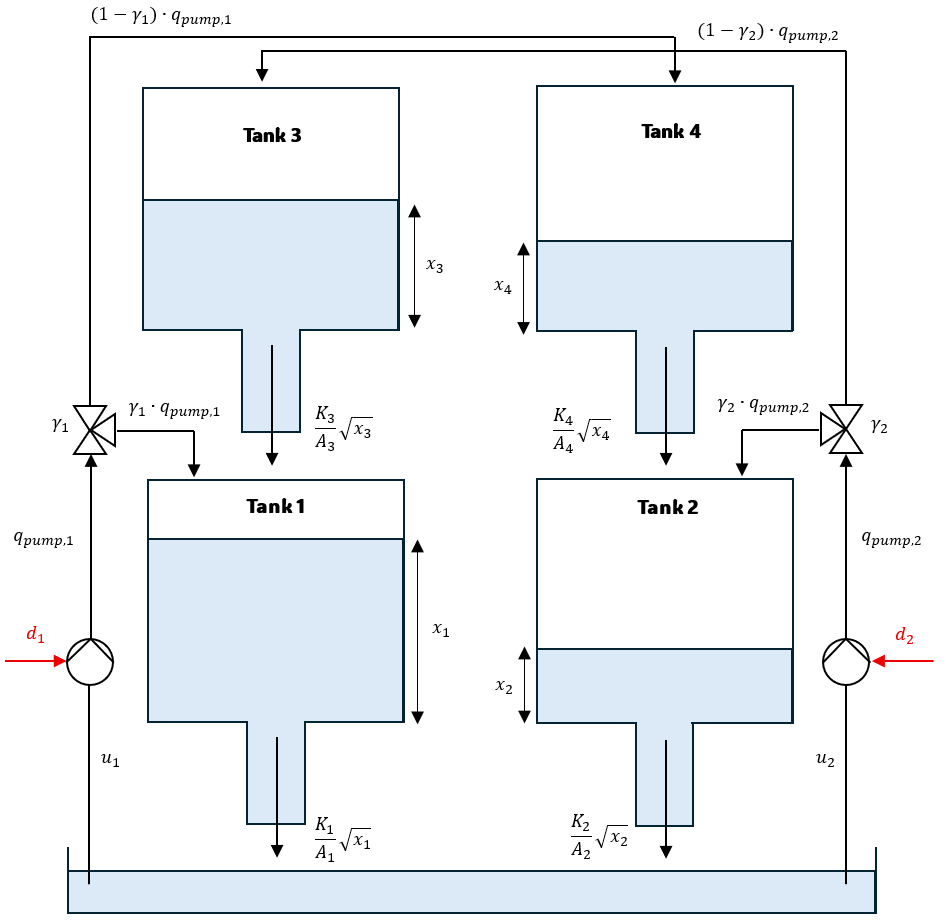

## Preliminaries

**Import Libraries**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

from __future__ import annotations
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
from itertools import product
import itertools
import matplotlib.cm as cm
from typing import Sequence, Union
from matplotlib.ticker import MultipleLocator
from typing import List

**Select Device**

In [ ]:
## ---------------------------- SELECT DEVICE ------------------------------- ##

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA GPU found")

CUDA available: True
CUDA device count: 1
Device name: NVIDIA A10G


## Open Loop

--- Simulation Results ---
Steady states (x1, x2, x3, x4): ['2.469', '1.653', '0.510', '0.327']
Settling times (Tanks 1, 2, 3, 4): {1: '20.53s', 2: '16.73s', 3: '8.76s', 4: '7.00s'}


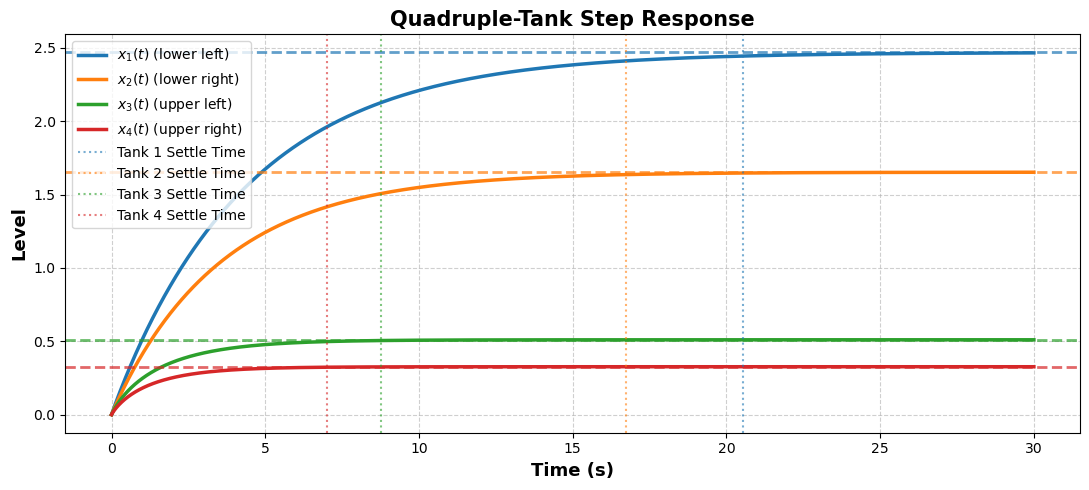

In [ ]:
"""

Quadruple-Tank Process Simulator
This script simulates the dynamics of a nonlinear quadruple-tank system.

"""

# ---------- Continuous-time dynamics (dx/dt) ----------
def quadruple_tank_rhs_x(x: np.ndarray, u1: float, u2: float, params: dict) -> np.ndarray:
    """
    Args:
        x: Numpy array of shape (4,) containing the current levels [x1, x2, x3, x4].
        u1: Input flow from pump 1.
        u2: Input flow from pump 2.
        params: Dictionary of system parameters containing:
            "A" (tuple): Areas [A1, A2, A3, A4].
            "k" (tuple): Outflow coefficients [k1, k2, k3, k4].
            "gamma" (tuple): Split fractions [γ1, γ2] to *lower* tanks.
            "d" (tuple, optional): Additive disturbances [d1, d2] on pumps.
    Returns:
        Numpy array of shape (4,) representing the derivatives [dx1/dt, dx2/dt, dx3/dt, dx4/dt].
    """
    # Unpack state variables and guard against negative levels.
    x1, x2, x3, x4 = [max(0.0, float(v)) for v in x]
    # Unpack parameters
    A1, A2, A3, A4 = params["A"]
    k1, k2, k3, k4 = params["k"]
    g1, g2 = params["gamma"]  # γ1, γ2
    # Get optional additive disturbances, defaulting to 0.0
    d1, d2 = params.get("d", (0.0, 0.0))
    # Calculate effective pump flows, guarding against negative flow
    u1_eff = max(0.0, u1 + d1)
    u2_eff = max(0.0, u2 + d2)
    # Calculate derivatives based on mass balance for each tank
    # Tank 1 (lower left)
    dx1 = (g1 * u1_eff + k3 * math.sqrt(x3) - k1 * math.sqrt(x1)) / A1
    # Tank 2 (lower right)
    dx2 = (g2 * u2_eff + k4 * math.sqrt(x4) - k2 * math.sqrt(x2)) / A2
    # Tank 3 (upper left)
    dx3 = ((1.0 - g2) * u2_eff - k3 * math.sqrt(x3)) / A3
    # Tank 4 (upper right)
    dx4 = ((1.0 - g1) * u1_eff - k4 * math.sqrt(x4)) / A4
    return np.array([dx1, dx2, dx3, dx4], dtype=float)

# ---------- One Euler step ----------
def euler_step_x(x: np.ndarray, u1: float, u2: float, dt: float, params: dict) -> np.ndarray:
    """
    Performs a single forward Euler integration step.
    Args:
        x: Current state vector [x1, x2, x3, x4].
        u1: Input flow from pump 1.
        u2: Input flow from pump 2.
        dt: Time step (sampling time).
        params: System parameters dictionary.
    Returns:
        Numpy array of shape (4,) for the next state vector, clamped at zero.
    """
    # Calculate derivatives
    dx = quadruple_tank_rhs_x(x, u1, u2, params)
    # Apply Euler's method: x_next = x_current + dt * dx/dt
    x_next = x + dt * dx
    # Clamp to nonnegative values
    return np.maximum(x_next, 0.0)

# ---------- Steady-state levels ----------
def steady_state_levels_x(u1: float, u2: float, params: dict) -> np.ndarray:
    """
    Calculates the analytical steady-state levels by setting dx/dt = 0.
    Args:
        u1: Input flow from pump 1.
        u2: Input flow from pump 2.
        params: System parameters dictionary.
    Returns:
        Numpy array of shape (4,) with steady-state levels [x1_ss, x2_ss, x3_ss, x4_ss].
    """
    # Unpack parameters
    k1, k2, k3, k4 = params["k"]
    g1, g2 = params["gamma"]
    d1, d2 = params.get("d", (0.0, 0.0))
    # Calculate effective pump flows
    u1_eff = max(0.0, u1 + d1)
    u2_eff = max(0.0, u2 + d2)
    # Solve for x_ss from dx/dt = 0
    x3_ss = (((1.0 - g2) * u2_eff) / k3)**2 if k3 > 0 else 0.0
    x4_ss = (((1.0 - g1) * u1_eff) / k4)**2 if k4 > 0 else 0.0
    x1_ss = ((g1 * u1_eff + (1.0 - g2) * u2_eff) / k1)**2 if k1 > 0 else 0.0
    x2_ss = ((g2 * u2_eff + (1.0 - g1) * u1_eff) / k2)**2 if k2 > 0 else 0.0
    return np.array([x1_ss, x2_ss, x3_ss, x4_ss], dtype=float)

# ---------- Open-loop step simulation (Euler) ----------
def simulate_quadruple_tank_step_response_x(
    x_init: tuple = (0.0, 0.0, 0.0, 0.0),
    u: tuple = (1.0, 1.0),
    gamma: tuple = (0.6, 0.6),
    k: tuple = (0.7, 0.7, 0.7, 0.7),
    A: tuple = (1.0, 1.0, 1.0, 1.0),
    d: tuple = (0.0, 0.0),
    dt: float = 0.01,
    simulation_time: float = 50.0,
    tol: float = 0.01
) -> tuple:
    """
    Runs an open-loop step simulation for the quadruple-tank system.
    Args:
        x_init: Initial levels (x1, x2, x3, x4).
        u: Step inputs (u1, u2).
        gamma: Split fractions (γ1, γ2) to lower tanks.
        k: Outflow coefficients (k1, k2, k3, k4).
        A: Tank areas (A1, A2, A3, A4).
        d: Pump inflow disturbances (d1, d2).
        dt: Integration time step.
        simulation_time: Total simulation duration.
        tol: Relative tolerance (e.g., 0.01 for 1%) for settling time detection.
    Returns:
        A tuple containing:
        - t_hist (np.ndarray): (N+1,) array of time stamps.
        - X_hist (np.ndarray): (N+1, 4) array of levels [x1, x2, x3, x4].
        - U_hist (np.ndarray): (N+1, 2) array of inputs [u1, u2].
        - settle_time (dict): {1: t1, 2: t2, 3: t3, 4: t4} where ti is the
                              settling time for tank i, or None if not settled.
        - x_ss (np.ndarray): (4,) array of steady-state levels.
    """
    params = {"A": tuple(A), "k": tuple(k), "gamma": tuple(gamma), "d": tuple(d)}
    steps = int(simulation_time / dt)
    # Initialize state and inputs
    x = np.array(x_init, dtype=float)
    u1, u2 = u
    # Initialize history lists to store results
    t_hist = [0.0]
    X_hist = [x.copy()]
    U_hist = [np.array([u1, u2], dtype=float)]
    t = 0.0
    # Calculate the target steady-state for settling time detection
    x_ss = steady_state_levels_x(u1, u2, params)
    # --- Settling time detection setup ---
    # The state needs to be in-band for 1.0 second to be "settled"
    inband_pts_needed = int(max(1, round(1.0 / dt)))
    buffers = {i: [] for i in range(4)}  # Stores timestamps of in-band points
    settled = {i: None for i in range(4)} # Stores the final settling time
    # --- Simulation loop ---
    for _ in range(steps):
        # Perform one integration step
        x = euler_step_x(x, u1, u2, dt, params)
        t += dt
        # Store results
        t_hist.append(t)
        X_hist.append(x.copy())
        U_hist.append([u1, u2])
        # --- Check per-tank settling ---
        for i in range(4):
            # Define the tolerance band (relative to steady-state value)
            band = tol * max(1e-12, x_ss[i])
            if abs(x[i] - x_ss[i]) <= band:
                # Point is inside the tolerance band, add timestamp to buffer
                buffers[i].append(t)
                # If tank isn't already marked as settled and buffer is full
                if settled[i] is None and len(buffers[i]) >= inband_pts_needed:
                    # Mark as settled, using the *first* timestamp in the buffer
                    settled[i] = buffers[i][0]
            else:
                # Point is outside the band, reset the buffer for this tank
                buffers[i].clear()
    # Format settle_time dict to use 1-based tank indexing
    settle_time = {i + 1: settled[i] for i in range(4)}
    return (
        np.array(t_hist, dtype=float),
        np.vstack(X_hist).astype(float),
        np.vstack(U_hist).astype(float),
        settle_time,
        x_ss
    )

# ---------------- Demo ----------------
if __name__ == "__main__":
    # Run a simulation
    t, X, U, settle_time, x_ss = simulate_quadruple_tank_step_response_x(
        x_init=(0, 0, 0, 0),
        u=(1.0, 1.0),
        gamma=(0.6, 0.5),
        k=(0.7, 0.7, 0.7, 0.7),
        A=(1.0, 1.0, 1.0, 1.0),
        d=(0.0, 0.0),
        dt=0.01,
        simulation_time=30.0,
        tol=0.01
    )
    # --- Print results ---
    print("--- Simulation Results ---")
    print(f"Steady states (x1, x2, x3, x4): {[f'{v:.3f}' for v in x_ss]}")
    st_print = {k: (f"{v:.2f}s" if v is not None else "Not Settled")
                for k, v in settle_time.items()}
    print(f"Settling times (Tanks 1, 2, 3, 4): {st_print}")
    # --- Plot results ---
    plt.figure(figsize=(11, 5))
    plt.title("Quadruple-Tank Step Response", fontsize=15, fontweight="bold")
    labels = [
        r"$x_1(t)$ (lower left)",
        r"$x_2(t)$ (lower right)",
        r"$x_3(t)$ (upper left)",
        r"$x_4(t)$ (upper right)"
    ]
    colors = plt.get_cmap('tab10')
    for i in range(4):
        # Plot tank level
        plt.plot(t, X[:, i], linewidth=2.5, label=labels[i], color=colors(i))
        # Plot steady-state horizontal line
        plt.axhline(x_ss[i], linestyle="--", linewidth=2, color=colors(i), alpha=0.7)
    # Plot vertical settling time lines
    for i in range(4):
        if settle_time[i + 1] is not None:
            plt.axvline(settle_time[i + 1], linestyle=":", alpha=0.6, color=colors(i),
                        label=f"Tank {i+1} Settle Time")
    plt.xlabel("Time (s)", fontsize=13, fontweight="bold")
    plt.ylabel("Level", fontsize=13, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## PINN-MPC Training

### Auxiliary Functions

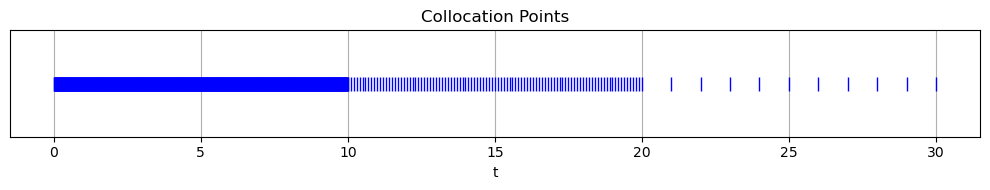

In [ ]:
## ------- GENERATE NON-UNIFORM COLLOCATION POINTS OVER TIME HORIZON -------- ##

def generate_collocation_points(horizon: float,
                                dt_dense: float = 0.01,
                                dt_medium: float = 0.05,
                                dt_sparse: float = 0.1) -> torch.Tensor:
    """
    Generates collocation points over a time horizon with non-uniform density,
    dividing the timeline into three regions with sparse sampling, medium
    sampling and dense sampling.
    Args:
        horizon (float): Total time horizon (s).
        dt_dense (float): Time step for dense region near t = 0.
        dt_medium (float): Time step for medium region.
        dt_sparse (float): Time step for sparse region near t = horizon.
    Returns:
        t_col (torch.Tensor): 1D tensor of sorted collocation points on (0, horizon].
    """
    # Define region boundaries (breakpoints)
    t_break1 = 2 * horizon / 3  # End of sparse region (from horizon)
    t_break2 = 1 * horizon / 3  # End of medium region (from t_break1)

    # Sparse region: [horizon, ..., t_break1 + dt_sparse]
    t_back_sparse = torch.arange(horizon, t_break1, -dt_sparse, device=DEVICE)
    # Medium region: [t_break1, ..., t_break2 + dt_medium]
    t_back_medium = torch.arange(t_break1, t_break2, -dt_medium, device=DEVICE)
    # Dense region: [t_break2, ..., 0 + dt_dense]
    t_back_dense = torch.arange(t_break2, 0.0, -dt_dense, device=DEVICE)
    # Concatenate all points
    t_col = torch.cat([
        t_back_sparse,
        t_back_medium,
        t_back_dense,
        torch.tensor([horizon], device=DEVICE)
    ])

    # Process the collected points
    t_col = torch.unique(t_col)      # Remove duplicates
    t_col = torch.sort(t_col).values # Sort ascending
    if t_col[-1] < horizon:
        t_col = torch.cat([t_col, torch.tensor([horizon], device=DEVICE)])

    return t_col

# -------------------------------- Demo ---------------------------------------#
# Generate the points
t_col = generate_collocation_points(
    horizon=30.0,
    dt_dense=0.01,
    dt_medium=0.1,
    dt_sparse=1.0
)

# Visualize collocation points
plt.figure(figsize=(10, 2))
plt.plot(t_col.cpu().numpy(),torch.zeros_like(t_col).cpu().numpy(),'|b', markersize=10)
plt.title("Collocation Points")
plt.xlabel("t"); plt.yticks([])
plt.grid(True); plt.tight_layout(); plt.show()

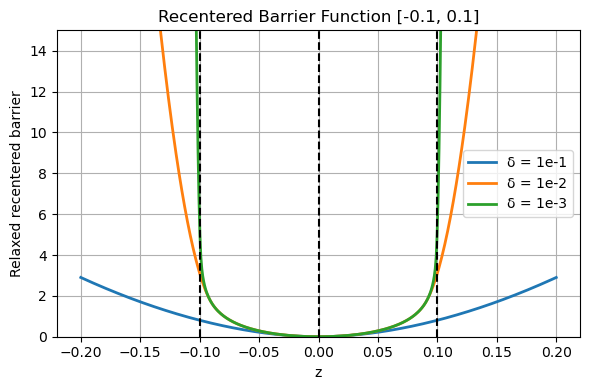

In [ ]:
## --------- RELAXED RECENTERED BARRIER FUNCTION FOR Δu CONSTRAINTS --------- ##

def barrier_du(z, z_min, z_max, delta):
    """
    Computes a relaxed, recentered barrier penalty to softly enforce:
        z_min <= z <= z_max

    This function is used in the study to apply smooth penalties on Δu, discouraging
    violations of specified bounds using a differentiable approximation.
    Args:
        z (Tensor): Quantity to penalize (can be scalar or tensor).
        z_min (float): Lower bound.
        z_max (float): Upper bound.
        delta (float): Positive relaxation parameter (controls smoothness near boundaries).
    Returns:
        B_rec (Tensor): Relaxed and recentered barrier penalty.
    """
    # Convert bounds and delta to tensors matching z's device and dtype
    z_min_t = torch.tensor(z_min, device=z.device, dtype=z.dtype)
    z_max_t = torch.tensor(z_max, device=z.device, dtype=z.dtype)
    delta_t = torch.tensor(delta, device=z.device, dtype=z.dtype)

    def B_single(x, delta):
        """
        Relaxed single-sided barrier.
        For x > delta:      -log(x)
        For x <= delta:     quadratic smoothing
        """
        return torch.where(
            x > delta,
            -torch.log(x),
            0.5 * ((x - 2 * delta) / delta) ** 2 - 0.5 - torch.log(delta)
        )

    # Apply single-sided barrier to both bounds
    B_raw = B_single(z - z_min_t, delta_t) + B_single(z_max_t - z, delta_t)

    # Recenter barrier so minimum penalty is zero (at midpoint)
    z_c = 0.5 * (z_min_t + z_max_t)
    B_center = B_single(z_c - z_min_t, delta_t) + B_single(z_max_t - z_c, delta_t)
    B_rec = B_raw - B_center

    return B_rec

# -------------------------------- Demo ---------------------------------------#
z_min, z_max = -0.1, 0.1
z = torch.linspace(-0.2, 0.2, 500)

B_1 = barrier_du(z, z_min, z_max, 1e-1)
B_2 = barrier_du(z, z_min, z_max, 1e-2)
B_3 = barrier_du(z, z_min, z_max, 1e-3)

plt.figure(figsize=(6, 4))
plt.plot(z.numpy(), B_1.numpy(), lw=2)
plt.plot(z.numpy(), B_2.numpy(), lw=2)
plt.plot(z.numpy(), B_3.numpy(), lw=2)
plt.legend(['δ = 1e-1', 'δ = 1e-2', 'δ = 1e-3'])
plt.ylim(0, 15)
plt.axvline(z_min, color='k', ls='--')
plt.axvline(z_max, color='k', ls='--')
plt.axvline(0.0, color='k', ls='--')
plt.xlabel('z'); plt.ylabel('Relaxed recentered barrier')
plt.title(f'Recentered Barrier Function [{z_min}, {z_max}]')
plt.grid(True); plt.tight_layout(); plt.show()

### Core Functions

In [ ]:
# ---------------------- PINN-MPC CONTROLLER MODULE --- ---------------------- #

class PINN_Controller_Quad(nn.Module):
    """
    PINN-MPC controller for the quadruple water-tank system with 4 states and 2 inputs (MIMO).

    Predicts trajectories [x1(t),x2(t),x3(t),x4(t)], [u1(t),u2(t)] that satisfy dynamics and constraints.

    Inputs:  [t, x0(4), u0(2), ysp(y1*, y2* = x1*, x2*), d0(2), e(2)=x0_lower - ysp]
    Outputs: [x1, x2, x3, x4, u1, u2]

    Constraints (soft):
        x3 ∈ [0, 0.6] m, x4 ∈ [0, 0.4] m,
        u1,u2 ∈ [0, 1] m³/s
        Δu1,Δu2 ∈ [−0.2, 0.2] m³/s
    """

    def __init__(self,
                 hidden_layers: List[int] = [64, 16, 16],
                 gamma=(0.6, 0.5),           # fixed splits to LOWER tanks
                 k=(0.7, 0.7, 0.7, 0.7),     # outflow coeffs
                 A=(1.0, 1.0, 1.0, 1.0),     # tank areas
                 x3_min=0.0, x3_max=0.6,
                 x4_min=0.0, x4_max=0.4,
                 u_min=0.0, u_max=1.0,
                 du_max=0.2):
        super().__init__()
        # --- Constraints ---
        self.x3_min_val = float(x3_min)
        self.x3_max_val = float(x3_max)
        self.x4_min_val = float(x4_min)
        self.x4_max_val = float(x4_max)
        self.u_min, self.u_max = float(u_min), float(u_max)
        self.du_max = float(du_max)

        # Fixed physics params as buffers (no grad)
        self.register_buffer("gamma_const", torch.tensor(gamma, dtype=torch.float32))  # [γ1, γ2]
        self.register_buffer("k_vec", torch.tensor(k, dtype=torch.float32))            # [k1,k2,k3,k4]
        self.register_buffer("A_vec", torch.tensor(A, dtype=torch.float32))            # [A1,A2,A3,A4]

        # --- Build Neural Network ---
        layers = []
        in_dim = 13   # [t] + [x0(4)] + [u0(2)] + [ysp(2)] + [d0(2)] + [e(2)]
        for width in hidden_layers:
            layers += [nn.Linear(in_dim, width), nn.Tanh()]
            in_dim = width
        layers += [nn.Linear(in_dim, 6)]  # 4 states + 2 inputs
        self.net = nn.Sequential(*layers)

    # ---------------- forward ----------------
    def forward(self, t, x0, u0, ysp, d0):
        """
        Forward pass of the network.
        Forward pass of the network (where B: batch and T: time)
        Args:
            t (torch.Tensor): Time tensor (B*T,)
            x0 (torch.Tensor): Initial state tensor (B*T,4)
            u0 (torch.Tensor): Initial input tensor (B*T,2)
            ysp (torch.Tensor): Setpoint tensor (B*T,2)
            d0 (torch.Tensor): Disturbance tensor (B*T,2)
        Returns:
            x_pred (torch.Tensor): Predicted state (B*T,4)
            u_pred (torch.Tensor): Predicted input (B*T,2)
        """
        e12 = x0[:, 0:2] - ysp
        inp = torch.cat([t.unsqueeze(-1), x0, u0, ysp, d0, e12], dim=-1)  # (B*T,13)
        out = self.net(inp)
        x_pred = out[:, :4]      # (B*T,4)
        u_pred = out[:, 4:]      # (B*T,2)
        return x_pred, u_pred

    def loss(self, bs, t_wp, N_WP, t_col, N_COL,
         x0, u0, ysp, d0,
         w_ode, w_ic, w_ytrk, w_utrk, w_du, w_u, w_x):
      """
      Calculates the composite loss function for the PINN-MPC.
      Initial Input Shapes:
          bs: int (batch size)
          t_wp: (N_WP,) (tracking points)
          N_WP: int (number of tracking points)
          t_col: (N_COL,) (collocation points)
          N_COL: int (number of collocation points)
          x0: (bs, 4) - Initial states
          u0: (bs, 2) - Initial inputs
          ysp: (bs, 2) - Output setpoints (for x1, x2)
          d0: (bs, 2) - Measured disturbances
      Returns:
            loss_total (torch.Tensor): scalar
            loss_components (tuple): (loss_ode, loss_ytrk, loss_utrk,
                                      loss_du, loss_u, loss_x, loss_ic)
      """

      # --- Retrieve System Constants ---
      gamma1, gamma2 = self.gamma_const[0], self.gamma_const[1]
      k1, k2, k3, k4 = self.k_vec
      A1, A2, A3, A4 = self.A_vec

      # --- Forward pass on tracking points ---
      t_wp = t_wp.clone().detach().requires_grad_(True)
      t_flat = t_wp.repeat(bs)
      # Repeat initial conditions for each tracking point
      x0_flat = x0.repeat_interleave(N_WP, 0)   # (bs*N_WP, 4)
      u0_flat = u0.repeat_interleave(N_WP, 0)   # (bs*N_WP, 2)
      ysp_flat = ysp.repeat_interleave(N_WP, 0) # (bs*N_WP, 2)
      d0_flat = d0.repeat_interleave(N_WP, 0)   # (bs*N_WP, 2)

      # Forward pass through the network for all tracking points
      # The network predicts state/control trajectories
      x_flat, u_flat = self(t_flat, x0_flat, u0_flat, ysp_flat, d0_flat) # (bs*N_WP, 4), (bs*N_WP, 2)
      # Reshape flat predictions back into 3D batch-time-state tensors
      x = x_flat.view(bs, N_WP, 4)  # (bs, N_WP, 4)
      u = u_flat.view(bs, N_WP, 2)  # (bs, N_WP, 2)

      # --- Forward pass on collocation points for ODE consistency ---
      t_col = t_col.clone().detach().requires_grad_(True)
      t_flat_col = t_col.repeat(bs)

      # Repeat initial conditions for each collocation point
      x0_c = x0.repeat_interleave(N_COL, 0)  # (bs*N_COL, 4)
      u0_c = u0.repeat_interleave(N_COL, 0)  # (bs*N_COL, 2)
      ysp_c = ysp.repeat_interleave(N_COL, 0) # (bs*N_COL, 2)
      d0_c = d0.repeat_interleave(N_COL, 0) # (bs*N_COL, 2)

      # Forward pass through the network (self) for all collocation points
      x_flat_c, u_flat_c = self(t_flat_col, x0_c, u0_c, ysp_c, d0_c) # (bs*N_COL, 4), (bs*N_COL, 2)
      # Reshape flat predictions back into 3D tensors
      x_c = x_flat_c.view(bs, N_COL, 4)  # (bs, N_COL, 4)
      u_c = u_flat_c.view(bs, N_COL, 2)  # (bs, N_COL, 2)

      # ───────── L_ode: ODE consistency ─────────
      # Create a tensor of ones for grad_outputs
      ones = torch.ones_like(t_flat_col)  # (bs*N_COL,)
      dxdt = []
      # Loop over each of the 4 states
      for i in range(4):
          # Calculate derivative dx/dt of the each state with respect to the
          # collocation points using automatic differentiation
          dxi = torch.autograd.grad(
              x_flat_c[:, i],    # Output tensor (bs*N_COL,)
              t_flat_col,        # Input tensor (bs*N_COL,)
              grad_outputs=ones, # Gradient of output w.r.t. itself is 1
              create_graph=True, # Create graph for higher-order derivatives
              retain_graph=True  # Keep graph for the next loop iteration
          )[0]
          dxdt.append(dxi) # List of 4 tensors, each (bs*N_COL,)
      # Stack the derivatives and reshape to 3D tensor
      dx_dt = torch.stack(dxdt, dim=-1).reshape(bs, N_COL, 4) # (bs, N_COL, 4)

      # Get components for ODEs
      # Controls at collocation points
      u1 = u_c[:, :, 0:1] # (bs, N_COL, 1)
      u2 = u_c[:, :, 1:2] # (bs, N_COL, 1)
      # Disturbances
      d1 = d0_c[:, 0].view(bs, N_COL, 1) # (bs, N_COL, 1)
      d2 = d0_c[:, 1].view(bs, N_COL, 1) # (bs, N_COL, 1)
      # States at collocation points
      x1 = x_c[:, :, 0:1] # (bs, N_COL, 1)
      x2 = x_c[:, :, 1:2] # (bs, N_COL, 1)
      x3 = x_c[:, :, 2:3] # (bs, N_COL, 1)
      x4 = x_c[:, :, 3:4] # (bs, N_COL, 1)
      eps = 1e-8 # Small epsilon to prevent sqrt(0)
      # Calculate nonlinear outflow terms
      s1 = torch.sqrt(torch.clamp(x1, min=0.0) + eps) # (bs, N_COL, 1)
      s2 = torch.sqrt(torch.clamp(x2, min=0.0) + eps) # (bs, N_COL, 1)
      s3 = torch.sqrt(torch.clamp(x3, min=0.0) + eps) # (bs, N_COL, 1)
      s4 = torch.sqrt(torch.clamp(x4, min=0.0) + eps) # (bs, N_COL, 1)

      # Calculate RHS of ODEs:
      r1 = dx_dt[:, :, 0:1] - (gamma1*(u1+d1) + k3*s3 - k1*s1)/A1 # (bs, N_COL, 1)
      r2 = dx_dt[:, :, 1:2] - (gamma2*(u2+d2) + k4*s4 - k2*s2)/A2 # (bs, N_COL, 1)
      r3 = dx_dt[:, :, 2:3] - ((1.0-gamma2)*(u2+d2) - k3*s3)/A3   # (bs, N_COL, 1)
      r4 = dx_dt[:, :, 3:4] - ((1.0-gamma1)*(u1+d1) - k4*s4)/A4   # (bs, N_COL, 1)
      # Concatenate residuals for all 4 states
      r_ode = torch.cat([r1, r2, r3, r4], dim=-1) # (bs, N_COL, 4)

      # Calculate Mean Squared Error loss
      # ─────────────────────────────────────────────────────────────────────
      loss_ode = w_ode * r_ode.pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_utrk: Input Tracking  ─────────
      # Compute steady-state targets u_ss and x_ss
      y1_sp = ysp[:, 0:1]  # (bs, 1) == x1*
      y2_sp = ysp[:, 1:2]  # (bs, 1) == x2*
      # Steady-state outflow terms
      a1 = k1 * torch.sqrt(torch.clamp(y1_sp, min=0.0) + eps)  # (bs, 1)
      a2 = k2 * torch.sqrt(torch.clamp(y2_sp, min=0.0) + eps)  # (bs, 1)
      Delta = (gamma1 + gamma2 - 1.0)
      # Initial disturbances
      d1_b = d0[:, 0:1]  # (bs, 1)
      d2_b = d0[:, 1:2]  # (bs, 1)
      if abs(float(Delta)) < 1e-12:
          # Handle degenerate case
          w1_ss = torch.zeros_like(a1)
          w2_ss = torch.zeros_like(a2)
      else:
          # Solve for steady-state total inflow w = u + d
          w1_ss = (gamma2 * a1 - (1.0 - gamma2) * a2) / Delta   # (bs, 1)
          w2_ss = (-(1.0 - gamma1) * a1 + gamma1 * a2) / Delta # (bs, 1)

      # Calculate steady-state control u_ss = w_ss - d
      u1_ss = w1_ss - d1_b                     # (bs, 1)
      u2_ss = w2_ss - d2_b                     # (bs, 1)
      u_ss = torch.cat([u1_ss, u2_ss], dim=1)  # (bs, 2)
      u_ss_wp = u_ss.unsqueeze(1).expand(bs, N_WP, 2) # (bs, N_WP, 2)
      # ─────────────────────────────────────────────────────────────────────
      loss_utrk = w_utrk * (u - u_ss_wp).pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_ytrk, L_xtrk : Output & State Tracking ─────────
      # Calculate steady-state for upper tanks (x3_sp, x4_sp)
      x3_sp = ((1.0 - gamma2) * w2_ss / k3).pow(2) # (bs, 1)
      x4_sp = ((1.0 - gamma1) * w1_ss / k4).pow(2) # (bs, 1)
      xsp_full = torch.cat([y1_sp, y2_sp, x3_sp, x4_sp], dim=1)  # (bs, 4)
      xsp_wp = xsp_full.unsqueeze(1).expand(bs, N_WP, 4)  # (bs, N_WP, 4)
      e_trk_all = x - xsp_wp # (bs, N_WP, 4)
      # ─────────────────────────────────────────────────────────────────────
      loss_ytrk = w_ytrk * e_trk_all.pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_Δu: Move Suppression ─────────
      # Create sequence [u0, u(t_1), ..., u(t_N)] for both inputs
      u_seq = torch.cat([u0.unsqueeze(1), u], dim=1)  # (bs, N_WP + 1, 2)
      dU = u_seq[:, 1:, :] - u_seq[:, :-1, :]         # (bs, N_WP, 2)
      # Apply barrier penalty
      delta = 0.01 # Barrier relaxation parameter
      # ─────────────────────────────────────────────────────────────────────
      loss_du = w_du * barrier_du(dU, -self.du_max, self.du_max, delta).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_ub: Soft bounds on u(t) ─────────
      # Define slack variables at each time step
      e_min_u = F.relu(self.u_min - u)  # (bs, N_WP, 2)
      e_max_u = F.relu(u - self.u_max)  # (bs, N_WP, 2)
      slack_u = e_min_u + e_max_u  # (bs, N_WP, 2)
      # ─────────────────────────────────────────────────────────────────────
      loss_u = w_u * slack_u.pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_xb: Soft bounds on x3(t), x4(t) ─────────
      # Get bound values
      x3_min_t = x.new_tensor(self.x3_min_val)
      x3_max_t = x.new_tensor(self.x3_max_val)
      x4_min_t = x.new_tensor(self.x4_min_val)
      x4_max_t = x.new_tensor(self.x4_max_val)

      # Define slack variables at each time step
      e_min_x3 = F.relu(x3_min_t - x[:, :, 2:3]) # (bs, N_WP, 1)
      e_max_x3 = F.relu(x[:, :, 2:3] - x3_max_t) # (bs, N_WP, 1)
      e_min_x4 = F.relu(x4_min_t - x[:, :, 3:4]) # (bs, N_WP, 1)
      e_max_x4 = F.relu(x[:, :, 3:4] - x4_max_t) # (bs, N_WP, 1)
      slack_x3 = e_min_x3 + e_max_x3             # (bs, N_WP, 1)
      slack_x4 = e_min_x4 + e_max_x4             # (bs, N_WP, 1)
      slack_x_all = torch.cat([slack_x3, slack_x4], dim=2) # (bs, N_WP, 2)
      # ─────────────────────────────────────────────────────────────────────
      loss_x = w_x * slack_x_all.pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── L_IC: Initial condition ─────────
      # Expand initial state x0 to match the shape of the first tracking point
      x0_wp = x0.unsqueeze(1)  # (bs, 1, 4)
      # ─────────────────────────────────────────────────────────────────────
      loss_ic = w_ic * (x[:, 0:1, :] - x0_wp).pow(2).mean() # scalar
      # ─────────────────────────────────────────────────────────────────────

      # ───────── Total Loss  ─────────
      # ---------------------------------------------------------------------
      loss_total = (loss_ode + loss_ytrk + loss_utrk +
                    loss_du + loss_u + loss_x + loss_ic) # scalar
      # ---------------------------------------------------------------------

      loss_components = (loss_ode, loss_ytrk, loss_utrk,
                         loss_du, loss_u, loss_x, loss_ic)

      return loss_total, loss_components

In [ ]:
## ----------------------- PINN-MPC TRAINING SCHEDULE ----------------------- ##

def train_PINN_Quad(T_INTERVAL, Ts,
                    model,
                    K1, K2, bs1, bs2,
                    x0_all, u0_all, ysp_all, d0_all,
                    lr1=1e-3, lr2=1e-4,
                    w_ode=1069.00, w_ic=2.44, w_ytrk=434.92, w_utrk=887.24,
                    w_du=55.08, w_u=330.47, w_x=21.55, keep_weights = 0.0):
    """
    Two-phase training loop for the PINN-MPC.

    This approach creates two phases:
    Phase 1: Trains on the primary terms: ODE consistency, set-point tracking,
             input tracking, and initial conditions. The bound violation terms can
             be disabled during this phase by setting keep_weights=0.0.
    Phase 2: Refines the solution by enabling all loss terms, including
             enforcing bounds (w_du, w_u, w_x). This phase typically
             uses a lower learning rate.
    Args:
        T_INTERVAL: Total prediction horizon (s).
        Ts: Controller sampling time (s).
        model: The PINN-MPC model to be trained.
        K1, K2: Number of epochs for Phase 1 and Phase 2.
        bs1, bs2: Batch size for Phase 1 and Phase 2.
        x0_all, u0_all, ysp_all, d0_all: The pre-loaded training samples.
        lr1, lr2: Learning rates for Phase 1 and Phase 2.
        w_ode, w_ytrk, ...: Weights for the various loss components.
        keep_weights (float): A factor (default: 0.0) to enable
                              weights (w_du, w_u, w_x) during Phase 1 as well.
    Returns:
        hist (list of float): Loss history over epochs
    """
    # GradScaler for Automatic Mixed Precision (AMP) training
    scaler = torch.amp.GradScaler()
    # List to store loss history
    hist = []

    # --- Create time vectors ---
    # Tracking points for control-oriented loss terms
    t_wp = torch.cat([torch.arange(0, T_INTERVAL, Ts, device=DEVICE),
                      torch.tensor([T_INTERVAL], device=DEVICE)])
    N_WP = t_wp.shape[0]
    # Collocation times for ODEs
    t_col = generate_collocation_points(horizon=T_INTERVAL,
                                        dt_dense=0.01, dt_medium=0.1, dt_sparse=1.0)
    N_COL = t_col.shape[0]

    # Shuffle the entire dataset once before starting.
    perm = torch.randperm(x0_all.size(0), device=x0_all.device)
    x0_all  = x0_all[perm]
    u0_all  = u0_all[perm]
    ysp_all = ysp_all[perm]
    d0_all  = d0_all[perm]

    ## ---------------------- Phase 1: Adam  --------------------- ##
    print("Phase 1:")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr1)

    # Single pass over all training samples
    for ep in range(1, K1 + 1):
        # --- Get the batch for this epoch ---
        start = (ep - 1) * bs1
        x0  = x0_all[start:start + bs1]
        u0  = u0_all[start:start + bs1]
        ysp = ysp_all[start:start + bs1]
        d0  = d0_all[start:start + bs1]

        # --- Forward pass with AMP ---
        with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=True):
            # Calculate loss
            loss, detail = model.loss(bs1, t_wp, N_WP, t_col, N_COL,
                                      x0, u0, ysp, d0,
                                      w_ode, w_ic, w_ytrk, w_utrk,
                                      keep_weights*w_du,
                                      keep_weights*w_u,
                                      keep_weights*w_x)

        if torch.isnan(loss):
            print(f"Loss is nan, terminating training at Phase 1, Epoch {ep}")
            break

        # --- Backpropagation ---
        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()
        # Include current loss value to list
        hist.append(loss.item())

        # --- Logging ---
        if ep == 1 or ep % 500 == 0 or ep == K1:
            print_loss(ep, loss, *detail)

    ## ---------------------- Phase 2: Adam  --------------------- ##
    if K2 == 0 or torch.isnan(loss):
        print("Training stopped after Phase 1.")
        return hist

    print("Phase 2:")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr2)

    for ep in range(1, K2 + 1):
        # Get the batch for this epoch.
        start = (ep - 1) * bs2
        x0  = x0_all[start:start + bs2]
        u0  = u0_all[start:start + bs2]
        ysp = ysp_all[start:start + bs2]
        d0  = d0_all[start:start + bs2]

        # --- Forward pass with AMP ---
        with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=True):
            # Calculate loss
            loss, detail = model.loss(bs2, t_wp, N_WP, t_col, N_COL,
                                      x0, u0, ysp, d0,
                                      w_ode, w_ic, w_ytrk, w_utrk,
                                      w_du, w_u, w_x)

        if torch.isnan(loss):
            print(f"Loss is nan, terminating training at Phase 2, Epoch {ep}")
            break

        # --- Backpropagation ---
        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()
        # Include current loss value to list
        hist.append(loss.item())

        # --- Logging ---
        if ep == 1 or ep % 500 == 0 or ep == K2:
            print_loss(ep, loss, *detail)

    return hist


## ------------------------- LOSS COMPONENT PROGRESS ------------------------ ##

def print_loss(ep, loss, loss_ode, loss_ytrk, loss_utrk, loss_du, loss_u, loss_x, loss_ic):
    """Helper function to print a formatted summary of loss components."""
    print(f"Epoch {ep:4d} | "
          f"Total: {loss:.4e} | "
          f"ODE: {loss_ode:.2e} | "
          f"x IC: {loss_ic:.2e} | "
          f"Track ysp: {loss_ytrk:.2e} | "
          f"Track u: {loss_utrk:.2e} | "
          f"Δu: {loss_du:.2e} | "
          f"x bounds: {loss_x:.2e} | "
          f"u bounds: {loss_u:.2e}")

### Training Procedure

**Training Samples**  
Each training episode samples $(y_{\text{sp}},\, x_{\text{IC}},\, u_{\text{IC}},\, d_{\text{IC}})$ from uniform distributions under feasibility constraints:

- Inputs: $u_{\text{IC}} = [u_{1,\text{IC}},\,u_{2,\text{IC}}]^\top \sim \mathcal{U}([0,1]~\text{m}^3/\text{s})$.
- Disturbances: $d_{\text{IC}} = [d_{1,\text{IC}},\,d_{2,\text{IC}}]^\top$ are set to zero with probability $20\%$; otherwise $d_{i,\text{IC}} \sim \mathcal{U}([0,0.4]~\text{m}^3/\text{s})$.
- Initial states: $x_{\text{IC}} = [x_{1,\text{IC}},\,x_{2,\text{IC}},\,x_{3,\text{IC}},\,x_{4,\text{IC}}]^\top$ are drawn within the disturbance-dependent feasible ranges:
  
  $$
  x_1 \in \left[\left(\frac{\gamma_1 d_{1,\text{IC}} + (1-\gamma_2)d_{2,\text{IC}}}{K_1}\right)^2,\;
               \left(\frac{\gamma_1 + (1-\gamma_2)}{K_1}\right)^2\right],
  $$
  $$
  x_2 \in \left[\left(\frac{\gamma_2 d_{2,\text{IC}} + (1-\gamma_1)d_{1,\text{IC}}}{K_2}\right)^2,\;
               \left(\frac{\gamma_2 + (1-\gamma_1)}{K_2}\right)^2\right],
  $$
  $$
  x_3 \in \left[\left(\frac{(1-\gamma_2)\,d_{2,\text{IC}}}{K_3}\right)^2,\;
               \left(\frac{(1-\gamma_2)}{K_3}\right)^2\right],\qquad
  x_4 \in \left[\left(\frac{(1-\gamma_1)\,d_{1,\text{IC}}}{K_4}\right)^2,\;
               \left(\frac{(1-\gamma_1)}{K_4}\right)^2\right].
  $$

- Set-points: $y_{\text{sp}} = [y_{1,\text{sp}},\,y_{2,\text{sp}}]^\top$ are constructed at steady state by first sampling $(u_{1,\text{ss}},u_{2,\text{ss}}) \sim \mathcal{U}([0,1]~\text{m}^3/\text{s})$ and then computing
  $$
  x_{1,\text{ss}}=\left(\frac{\gamma_1\,(u_{1,\text{ss}}+d_{1,\text{IC}}) + (1-\gamma_2)\,(u_{2,\text{ss}}+d_{2,\text{IC}})}{K_1}\right)^2,\quad
  x_{2,\text{ss}}=\left(\frac{\gamma_2\,(u_{2,\text{ss}}+d_{2,\text{IC}}) + (1-\gamma_1)\,(u_{1,\text{ss}}+d_{1,\text{IC}})}{K_2}\right)^2,
  $$
  and setting $y_{1,\text{sp}}=x_{1,\text{ss}}$, $y_{2,\text{sp}}=x_{2,\text{ss}}$.

This sampling ensures each episode is physically attainable under the actuator, disturbance, and output limits.

In [ ]:
## ------ LOAD TRAINING SAMPLES for 1e6 EPISODES (bs = 100, K = 10000) ------ ##

DATAFILE_X    = "mimo_training_samples_x.pt"
DATAFILE_YSP  = "mimo_training_samples_ysp.pt"
DATAFILE_UD = "mimo_training_samples_ud.pt"
data_x    = torch.load(DATAFILE_X,    map_location="cpu")
data_ysp  = torch.load(DATAFILE_YSP,  map_location="cpu")
data_ud = torch.load(DATAFILE_REST, map_location="cpu")
x0_all  = data_x["x0_all"].to(DEVICE, non_blocking=True)
ysp_all = data_ysp["ysp_all"].to(DEVICE, non_blocking=True)
u0_all  = data_ud["u0_all"].to(DEVICE, non_blocking=True)
d0_all  = data_ud["d0_all"].to(DEVICE, non_blocking=True)

print(f"Training Samples Loaded.")

Training Samples Loaded.


In [ ]:
## ----------------------------- TRAIN PINN-MPC  ----------------------------- ##

# Reproducibility & housekeeping
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Instantiate PINN-MPC Model
# Architecture: [input (11) → 64 → 16 → 16 → output(6)]
model = PINN_Controller_Quad(
    hidden_layers=[64, 16, 16],
    gamma=(0.6, 0.5),
    k=(0.7, 0.7, 0.7, 0.7),
    A=(1.0, 1.0, 1.0, 1.0),
    x3_min=0.0, x3_max=0.6,
    x4_min=0.0, x4_max=0.4,
    u_min=0.0, u_max=1.0,
    du_max=0.2
).to(DEVICE)
# Print number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in model: {trainable_params}")

# Time settings
T_INTERVAL = 30.0    # Prediction horizon [s]
Ts         = 1.0     # Controller sampling time [s]

# Adam training settings
K  = 10000                  # Epochs in Phase 1 and Phase 2
bs = 100                    # Batch size in Phase 1 and Phase 2
lr1 = 0.004452773481136963  # Tuned learning rate for Phase 1
lr2 = 0.0015144628796707415 # Tuned learning rate for Phase 2

# Loss Penalty Weights
w_ode  = 1069.0047672275045     # ODE consistency
w_ic   = 2.4442013642739        # Initial condition matching
w_ytrk = 434.92412596497064     # Set-point tracking
w_utrk = 887.2431984586441      # Input tracking
w_du   = 55.076284619704033     # Move suppression (Δu)
w_u    = 330.4681946536424      # Actuator bounds constraint (u)
w_x    = 21.54583242643753      # State bounds constraint (x3, x4)

# Train and Time the PINN-MPC (2-phase Adam schedule)
start_time = time.time()
loss_history = train_PINN_Quad(
    T_INTERVAL, Ts,                                        # Prediction horizon and controller sampling time
    model,                                                 # PINN-MPC with initialized weights and biases
    K, K, bs, bs,                                          # Epochs (K1 for Phase 1, K1 for Phase 2) and batch sizes
    x0_all, u0_all, ysp_all, d0_all,                       # The complete, pre-sampled dataset
    lr1=lr1, lr2=lr2,                                      # Learning Rates
    w_ode=w_ode, w_ic=w_ic, w_ytrk=w_ytrk, w_utrk=w_utrk,  # Primary loss terms
    w_du=w_du, w_u=w_u, w_x=w_x,                           # Bound violation terms
)

end_time = time.time()
print(f"--- Training Complete ---")
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Using device: cuda
Total number of trainable parameters in model: 2310
Phase 1:
Epoch    1 | Total: 9.1096e+02 | ODE: 1.29e+02 | x IC: 2.47e+00 | Track ysp: 5.20e+02 | Track u: 2.59e+02 | Δu: 0.00e+00 | x bounds: 0.00e+00 | u bounds: 0.00e+00
Epoch  500 | Total: 2.0590e+01 | ODE: 6.77e-01 | x IC: 5.02e-01 | Track ysp: 2.13e+00 | Track u: 1.73e+01 | Δu: 0.00e+00 | x bounds: 0.00e+00 | u bounds: 0.00e+00
Epoch 1000 | Total: 2.8034e+00 | ODE: 4.58e-01 | x IC: 5.12e-01 | Track ysp: 3.07e-01 | Track u: 1.53e+00 | Δu: 0.00e+00 | x bounds: 0.00e+00 | u bounds: 0.00e+00
Epoch 1500 | Total: 1.2758e+00 | ODE: 2.08e-01 | x IC: 5.56e-01 | Track ysp: 1.36e-01 | Track u: 3.76e-01 | Δu: 0.00e+00 | x bounds: 0.00e+00 | u bounds: 0.00e+00
Epoch 2000 | Total: 1.3418e+00 | ODE: 2.19e-01 | x IC: 5.78e-01 | Track ysp: 1.50e-01 | Track u: 3.95e-01 | Δu: 0.00e+00 | x bounds: 0.00e+00 | u bounds: 0.00e+00
Epoch 2500 | Total: 1.2076e+00 | ODE: 2.28e-01 | x IC: 5.06e-01 | Track ysp: 9.87e-02 | Track u: 3.75e-01

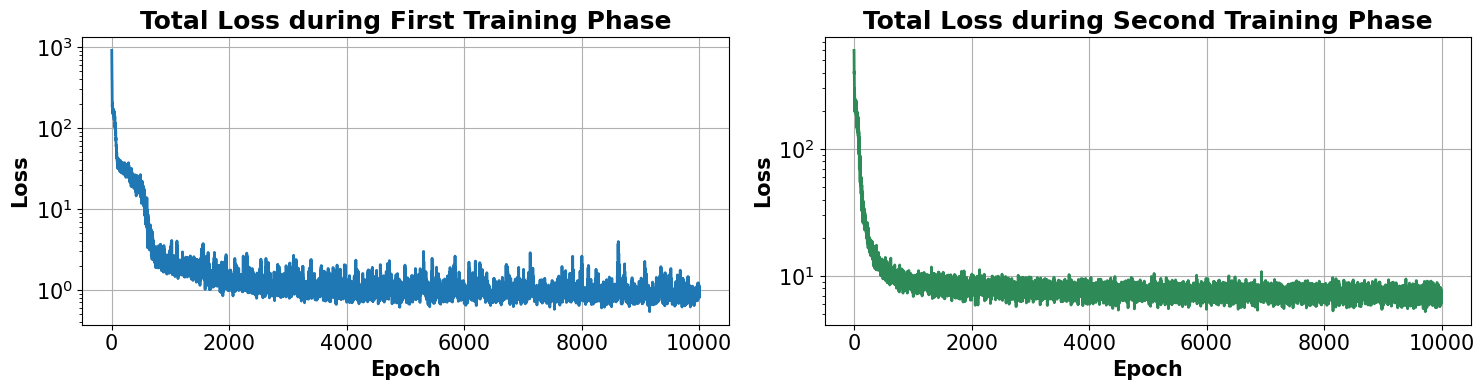

In [ ]:
## -------------- PLOT LOSS EVOLUTION FOR EACH TRAINING PHASE --------------- ##

# Visualize training loss across both optimization phases using a logarithmic scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Phase 1 loss
ax1.plot(loss_history[:K], linewidth=2)
ax1.set_title("Total Loss during First Training Phase", fontsize=18, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=15, fontweight='bold')
ax1.set_yscale('log')  # Set y-axis to log scale
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True)
# Phase 2 loss
ax2.plot(loss_history[K:], linewidth=2, color="seagreen")
ax2.set_title("Total Loss during Second Training Phase", fontsize=18, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax2.set_ylabel("Loss", fontsize=15, fontweight='bold')
ax2.set_yscale('log')  # Set y-axis to log scale
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True)
plt.tight_layout()
plt.show()

## PINN-MPC Validation

### Functions

In [ ]:
## --- PARALLEL CLOSED-LOOP SIMULATION OVER MULTIPLE INSTANCES (PINN-MPC) --- ##

@torch.no_grad()
def rollout_batch(model, x0, ysp_target, u0, d0,
                  dt=0.01, Ts=1.0, noise=0.0,
                  simulation_time=25.0, sp_change=5.0, d_step=30.0):
    """
    Performs a parallel, closed-loop simulation for a batch of B systems.

    This function simulates `B` quadruple-tank systems simultaneously, each
    with its own initial condition (x0), setpoint target (ysp_target),
    and disturbance (d0).

    At each control interval (Ts), it queries the PINN-MPC model for the
    optimal control action. It then simulates the plant's response to that
    action using a fine-grained Euler integration (dt) until the next
    control interval.

    Args:
        model: The trained PINN-MPC controller model.
        x0 (torch.Tensor): (B, 4) tensor of initial tank levels [x1,x2,x3,x4].
        ysp_target (torch.Tensor): (B, 2) tensor of target setpoints [y1*, y2*].
        u0 (torch.Tensor): (B, 2) tensor of initial inputs [u1, u2].
        d0 (torch.Tensor): (B, 2) tensor of disturbance magnitudes [d1, d2].
        dt (float): Plant simulation time step (Euler integration step).
        Ts (float): Controller sampling time (how often the MPC is queried).
        noise (float): Std dev of Gaussian noise to add to state measurements.
        simulation_time (float): Total duration of the closed-loop simulation.
        sp_change (float): Time (in sec) at which to switch from x0 to ysp_target.
        d_step (float): Time (in sec) at which to apply the disturbance d0.

    Returns:
        A tuple of history tensors:
        - t_hist (torch.Tensor): (N,) 1D tensor of time stamps.
        - X_hist (torch.Tensor): (B, N, 4) tensor of state (level) history.
        - U_hist (torch.Tensor): (B, N, 2) tensor of control input history.
        - YSP_hist (torch.Tensor): (B, N, 2) tensor of setpoint history.
        - D_hist (torch.Tensor): (B, N, 2) tensor of disturbance history.
    """
    # --- Initialization ---
    DEVICE = next(model.parameters()).device
    # Get physics parameters from the model
    g1, g2 = model.gamma_const[0].item(), model.gamma_const[1].item()
    k1, k2, k3, k4 = model.k_vec.tolist()
    A1, A2, A3, A4 = model.A_vec.tolist()
    eps = 1e-8  # For numerical stability in torch.sqrt

    B = x0.shape[0]  # Batch size
    n_query = int(simulation_time / Ts)  # Number of controller queries
    n_inner = int(Ts / dt)             # Plant simulation steps per query

    # Initialize current state, previous input, and disturbance
    x_curr = x0.to(DEVICE).clone()
    # Simulate measurement noise
    x_meas = (x_curr + torch.randn_like(x_curr) * noise).clamp_min(0.0)
    u_prev = (u0.to(DEVICE) if u0 is not None else torch.zeros(B, 2, device=DEVICE))
    d0 = d0.to(DEVICE)

    # Initial setpoint is the initial state's controlled outputs (x1, x2)
    ysp_init = x0[:, :2].to(DEVICE)

    # History lists to store results from each fine step (dt)
    t_hist, X_hist, U_hist, YSP_hist, D_hist = [], [], [], [], []
    t_curr = 0.0

    # --- Main Simulation Loop ---
    # This loop iterates at the *controller sampling rate* (Ts).
    for _ in range(n_query):
        # --- Determine current setpoint and disturbance ---
        # Setpoint steps from initial state to target state at t=sp_change
        ysp_k = torch.where(
            (torch.full((B, 1), t_curr, device=DEVICE) < sp_change),
            ysp_init,
            ysp_target.to(DEVICE)
        )
        # Disturbance steps from 0 to d0 at t=d_step
        d_k = torch.where(
            (torch.full((B, 1), t_curr, device=DEVICE) < d_step),
            torch.zeros_like(d0),
            d0
        )

        # --- Controller Query ---
        # Get the optimal control action from the PINN-MPC model.
        # We query at t=0 relative to the *start* of the prediction horizon.
        t_query = torch.full((B,), 0, device=DEVICE)
        # model() returns (predicted_states, predicted_inputs)
        _, u_pred = model(t_query, x_meas, u_prev, ysp_k, d_k)
        u_cmd = u_pred  # Use the first predicted input (u_0)

        # --- Inner Plant Simulation (Euler Integration) ---
        # This loop iterates at the *plant simulation rate* (dt).
        x_inner = x_curr.clone()
        for _ in range(n_inner):
            # Get sqrt of levels for flow calculation
            s1 = torch.sqrt(x_inner[:, 0:1].clamp_min(0.0) + eps)
            s2 = torch.sqrt(x_inner[:, 1:2].clamp_min(0.0) + eps)
            s3 = torch.sqrt(x_inner[:, 2:3].clamp_min(0.0) + eps)
            s4 = torch.sqrt(x_inner[:, 3:4].clamp_min(0.0) + eps)

            # Apply the quadruple-tank dynamics (same as in simulation)
            # Note: u_cmd and d_k are held constant over the Ts interval.
            dx1 = (g1 * (u_cmd[:, 0:1] + d_k[:, 0:1]) + k3 * s3 - k1 * s1) / A1
            dx2 = (g2 * (u_cmd[:, 1:2] + d_k[:, 1:2]) + k4 * s4 - k2 * s2) / A2
            dx3 = ((1.0 - g2) * (u_cmd[:, 1:2] + d_k[:, 1:2]) - k3 * s3) / A3
            dx4 = ((1.0 - g1) * (u_cmd[:, 0:1] + d_k[:, 0:1]) - k4 * s4) / A4

            # Concatenate derivatives and perform one Euler step
            dx = torch.cat([dx1, dx2, dx3, dx4], dim=1)
            x_inner = (x_inner + dx * dt).clamp_min(0.0)

            # --- Record History at every `dt` step ---
            t_curr += dt
            t_hist.append(t_curr)
            X_hist.append(x_inner.detach().cpu())
            U_hist.append(u_cmd.detach().cpu())
            YSP_hist.append(ysp_k.detach().cpu())
            D_hist.append(d_k.detach().cpu())

        # --- Update State for Next Controller Query ---
        # The state at the end of the inner loop is the new "current state"
        x_curr = x_inner
        # Apply new measurement noise
        x_meas = (x_curr + torch.randn_like(x_curr) * noise).clamp_min(0.0)
        # Update the "previous input" for the next controller query
        u_prev = u_cmd

    # --- Format and Return Results ---
    # Convert history lists to stacked tensors
    t_hist = torch.tensor(t_hist, device=DEVICE)
    X_hist = torch.stack(X_hist, dim=1).to(DEVICE)     # (B, N, 4)
    U_hist = torch.stack(U_hist, dim=1).to(DEVICE)     # (B, N, 2)
    YSP_hist = torch.stack(YSP_hist, dim=1).to(DEVICE) # (B, N, 2)
    D_hist = torch.stack(D_hist, dim=1).to(DEVICE)     # (B, N, 2)

    return t_hist, X_hist, U_hist, YSP_hist, D_hist

@torch.no_grad()
def evaluate_model_parallel_dist(model, x0_grid, ysp_grid, d0_grid,
                                 dt=0.01, Ts=1.0, noise=0.0,
                                 simulation_time=25.0,
                                 sp_change=5.0, d_step=30.0) -> dict:
    """
    Evaluates the model's closed-loop performance over a grid of scenarios.

    This function runs a parallel simulation (using `rollout_batch`) for
    a batch of initial conditions (x0), setpoints (ysp), and disturbances (d0).
    It then computes final steady-state error (SSE) metrics to quantify
    the controller's performance.

    Args:
        model: The trained PINN-MPC controller model.
        x0_grid (torch.Tensor): (B, 4) tensor of initial tank levels.
        ysp_grid (torch.Tensor): (B, 2) tensor of target setpoints [y1*, y2*].
        d0_grid (torch.Tensor): (B, 2) tensor of disturbance magnitudes.
        dt (float): Plant simulation time step.
        Ts (float): Controller sampling time.
        noise (float): Std dev of measurement noise.
        simulation_time (float): Total duration of the simulation.
        sp_change (float): Time to apply the new setpoint.
        d_step (float): Time to apply the disturbance.

    Returns:
        A dictionary containing various performance metrics, such as:
        - "final_sse": (B, 2) Final steady-state error (x_final - ysp).
        - "final_sse_abs": (B, 2) Absolute final SSE.
        - "final_perc": (B, 2) Percentage final SSE.
        - "per_case_max_abs": (B,) Max absolute error per scenario.
        - "best_ysp": (2,) The setpoint from the "best" case (min max error).
        - "max_final_error": (float) Max SSE across all scenarios and tanks.
        - "mean_abs_error": (float) Mean SSE across all scenarios and tanks.
    """
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()
    DEVICE = next(model.parameters()).device

    # --- Handle Empty Input ---
    # If no scenarios are provided, return an empty results dictionary
    if x0_grid.numel() == 0:
        empty = torch.empty(0, 2)
        return {
            "final_sse":         empty,
            "final_sse_abs":     empty,
            "final_perc":        empty,
            "per_case_max_abs":  torch.empty(0),
            "argmin_idx":        None,
            "best_ysp":          None,
            "best_max_abs":      None,
            "max_final_error":   0.0,
            "min_final_error":   0.0,
            "max_perc_error":    0.0,
            "mean_abs_error":    0.0,
        }

    # --- Move Data to Device ---
    x0  = x0_grid.to(DEVICE)
    ysp = ysp_grid.to(DEVICE)       # (B, 2) ← lower setpoints only
    d0  = d0_grid.to(DEVICE)

    # --- Run Parallel Rollout ---
    # Call the simulation function from closed_loop_simulator.py
    # Pass u0=None to let the controller start from a zero-input assumption
    t, X, U, _, _ = rollout_batch(
        model, x0, ysp, None, d0,
        dt=dt, Ts=Ts, noise=noise,
        simulation_time=simulation_time,
        sp_change=sp_change, d_step=d_step
    )

    # --- Calculate Final Error Metrics ---
    # Get the final state of the lower tanks (x1, x2) and move to CPU
    final_x_lo = X[:, -1, :2].cpu()   # (B, 2)
    ysp_cpu    = ysp.cpu()            # (B, 2)

    # Calculate final steady-state error (SSE)
    final_sse  = final_x_lo - ysp_cpu   # (B, 2)
    # Calculate percentage error (relative to setpoint)
    final_perc = final_sse / ysp_cpu.clamp(min=1e-6) * 100.0
    # Find the worst-case error (max over tanks) for each scenario
    per_case_max_abs = final_sse.abs().max(dim=1).values # (B,)

    # --- Find the "Best" Scenario ---
    # The "best" case is the one with the *smallest* max absolute error
    best_idx = int(per_case_max_abs.argmin().item())
    best_ysp = ysp_cpu[best_idx]
    best_val = float(per_case_max_abs[best_idx].item())

    # --- Package and Return Results ---
    return {
        "final_sse":         final_sse,
        "final_sse_abs":     final_sse.abs(),
        "final_perc":        final_perc,
        "per_case_max_abs":  per_case_max_abs,
        "argmin_idx":        best_idx,
        "best_ysp":          best_ysp,
        "best_max_abs":      best_val,
        "max_final_error":   final_sse.abs().max().item(),
        "min_final_error":   final_sse.abs().min().item(),
        "max_perc_error":    final_perc.abs().max().item(),
        "mean_abs_error":    final_sse.abs().mean().item()
    }

### Run

In [ ]:
## ------------ VALIDATE PINN-MPC ON SET-POINT TRACKING SCENARIOS ----------- ##

# Load test samples
data = torch.load('mimo_test_samples.pt', map_location="cpu")  # always portable
x0_sp  = data["x0_sp"].to(DEVICE, non_blocking=True)
u0_sp  = data["u0_sp"].to(DEVICE, non_blocking=True)
ysp_sp = data["ysp_sp"].to(DEVICE, non_blocking=True)
d0_sp  = data["d0_sp"].to(DEVICE, non_blocking=True)
x0_dr  = data["x0_dr"].to(DEVICE, non_blocking=True)
u0_dr  = data["u0_dr"].to(DEVICE, non_blocking=True)
ysp_dr = data["ysp_dr"].to(DEVICE, non_blocking=True)
d0_dr  = data["d0_dr"].to(DEVICE, non_blocking=True)

# SP TRACKING
metrics_sp = evaluate_model_parallel_dist(
    model, x0_sp, ysp_sp, d0_sp,dt=0.01, Ts=1.0,
    sp_change=0.0, d_step=0.0,simulation_time=30.0)

# Metrics
mae_sp_all = metrics_sp["final_sse_abs"].mean().item()
max_sp_all = metrics_sp["final_sse_abs"].max().item()
mae_sp_t1, mae_sp_t2 = metrics_sp["final_sse_abs"].mean(dim=0).tolist()
max_sp_t1, max_sp_t2 = metrics_sp["final_sse_abs"].max(dim=0).values.tolist()
min_sp_t1, min_sp_t2 = metrics_sp["final_sse_abs"].min(dim=0).values.tolist()
print(f"[SP] Mean final |error| : T1={mae_sp_t1:.4f} m, T2={mae_sp_t2:.4f} m")
print(f"[SP] Max final |error| per tank: T1={max_sp_t1:.4f} m, T2={max_sp_t2:.4f} m")
print(f"[SP] Min final |error| per tank: T1={min_sp_t1:.4f} m, T2={min_sp_t2: .4f} m")
print("---------------------------------------------------------------------")

# DR
metrics_dr = evaluate_model_parallel_dist(
    model, x0_dr, ysp_dr, d0_dr ,dt=0.01, Ts=1.0,
    sp_change=0.0, d_step=0.0,simulation_time=30.0)

# Metrics
mae_dr_all = metrics_dr["final_sse_abs"].mean().item()
max_dr_all = metrics_dr["final_sse_abs"].max().item()
mae_dr_t1, mae_dr_t2 = metrics_dr["final_sse_abs"].mean(dim=0).tolist()
max_dr_t1, max_dr_t2 = metrics_dr["final_sse_abs"].max(dim=0).values.tolist()
min_dr_t1, min_dr_t2 = metrics_dr["final_sse_abs"].min(dim=0).values.tolist()
print(f"[DR] Mean final |error| : T1={mae_dr_t1:.4f} m, T2={mae_dr_t2:.4f} m")
print(f"[DR] Max final |error| per tank: T1={max_dr_t1:.4f} m, T2={max_dr_t2:.4f} m")
print(f"[DR] Min final |error| per tank: T1={min_dr_t1:.4f} m, T2={min_dr_t2: .4f} m")
print("---------------------------------------------------------------------")

[SP] Mean final |error| : T1=0.0208 m, T2=0.0183 m
[SP] Max final |error| per tank: T1=0.0485 m, T2=0.0395 m
[SP] Min final |error| per tank: T1=0.0000 m, T2= 0.0000 m
---------------------------------------------------------------------
[DR] Mean final |error| : T1=0.0202 m, T2=0.0130 m
[DR] Max final |error| per tank: T1=0.0670 m, T2=0.0533 m
[DR] Min final |error| per tank: T1=0.0000 m, T2= 0.0000 m
---------------------------------------------------------------------


## Multi-Case Closed-Loop Plots

### Function

In [ ]:
## ------------------ MULTI-CASE INFERENCE PINN-MPC PLOTS ------------------- ##

@torch.no_grad()
def evaluate_multi_case(
    model,
    x0=(0.2, 0.2, 0.0, 0.0),    # Initial state [x1,x2,x3,x4]
    u0=(0.0, 0.0),              # Initial input [u1,u2]
    ysp_list=[(1.0, 1.0)],       # List of (y1*, y2*) setpoints for each episode
    d0_list=[(0.0, 0.0)],        # List of (d1, d2) disturbances for each episode
    Ts: float = 1.0,
    dt_inner: float = None,      # Plant sim step. If None -> Ts/substeps
    substeps: int = 100,          # Inner steps per Ts when dt_inner is None
    integrator: str = "rk2",     # "rk2" or "euler"
    noise=[0.0, 0.0, 0.0, 0.0],                   # scalar or length-4 iterable (per-state stds)
    simulation_time: float = 20.0, # Duration *per episode*
    d_step: float = 30.0,        # Time *within each episode* to apply disturbance
    shift_time: float = 0.0,
    plot_disturbance: bool = True,
    ylimits_lo='auto',
    ylimits_up='auto',
    store_stride: int = 1,
    # upper-tank bounds to draw (lines); mins assumed 0
    x3_max_bound: float = 0.6,
    x4_max_bound: float = 0.4,
):
    """
    Fast multi-case rollout for the quadruple-tank PINN-MPC.

    • Controller receives only (y1*, y2*) as setpoints.
    • One controller call per Ts; plant integrated in NumPy (RK2/Euler).
    • Disturbance is OFF until t_local >= d_step in EACH episode.
    • Preallocated arrays + optional downsample via store_stride.
    • Plots: (x1,x2) vs SP, (x3,x4) with bounds, u1/u2, and (optional) d1/d2.

    Parameters
    ----------
    noise : float or iterable of 4 floats
        Standard deviation of measurement noise added to x before control.
        If scalar, applied to all states. If length-4, per-state stds; zeros
        disable noise on those channels.
    """

    # --- Helper: make a 1x4 tensor from scalar or vector ---
    def _as_1x4_tensor(x, device, dtype):
        """Converts scalar or iterable to a (1,4) noise tensor."""
        if isinstance(x, (int, float)):
            return torch.full((1, 4), float(x), device=device, dtype=dtype)
        return torch.as_tensor(x, device=device, dtype=dtype).reshape(1, 4)

    assert len(ysp_list) == len(d0_list), "ysp_list and d0_list must have same length"

    # --- Setup: Model, Device, and Physics Parameters ---
    DEVICE = next(model.parameters()).device
    DTYPE = next(model.parameters()).dtype
    model.eval()

    # Read physics parameters once from the model
    g1, g2 = [float(x) for x in model.gamma_const.tolist()]
    k1, k2, k3, k4 = [float(x) for x in model.k_vec.tolist()]
    A1, A2, A3, A4 = [float(x) for x in model.A_vec.tolist()]
    eps = 1e-8

    # --- Internal NumPy-based Plant Simulator ---
    def rhs(x, u, d):
        """NumPy RHS function for the plant dynamics."""
        s1 = np.sqrt(max(x[0], 0.0) + eps)
        s2 = np.sqrt(max(x[1], 0.0) + eps)
        s3 = np.sqrt(max(x[2], 0.0) + eps)
        s4 = np.sqrt(max(x[3], 0.0) + eps)
        dx1 = (g1 * (u[0] + d[0]) + k3 * s3 - k1 * s1) / A1
        dx2 = (g2 * (u[1] + d[1]) + k4 * s4 - k2 * s2) / A2
        dx3 = ((1.0 - g2) * (u[1] + d[1]) - k3 * s3) / A3
        dx4 = ((1.0 - g1) * (u[0] + d[0]) - k4 * s4) / A4
        return np.array([dx1, dx2, dx3, dx4], dtype=np.float64)

    def step(x, u, d, dt):
        """A single integration step for the plant."""
        if integrator.lower() == "rk2":
            # 2nd-order Runge-Kutta (midpoint method)
            k_1 = rhs(x, u, d)
            x_m = np.maximum(x + 0.5 * dt * k_1, 0.0)
            k_2 = rhs(x_m, u, d)
            return np.maximum(x + dt * k_2, 0.0)
        else:
            # Forward Euler
            return np.maximum(x + dt * rhs(x, u, d), 0.0)

    # --- Simulation Loop Setup ---
    if dt_inner is None:
        dt_inner = Ts / substeps
    n_inner = max(1, int(round(Ts / dt_inner)))
    dt_inner = Ts / n_inner  # Recalculate exact dt_inner

    # Storage for stitched episodes
    T_all, X_all, U_all, YSP_all, D_all = [], [], [], [], []
    t_global = 0.0  # for stitched plots only

    # Prepare noise tensor (1x4) once
    noise_std_1x4 = _as_1x4_tensor(noise, DEVICE, DTYPE)

    with torch.inference_mode():
        # Initialize state and input for the first episode
        x_prev = np.array(x0, dtype=np.float64)
        u_prev = np.array(u0, dtype=np.float64)

        # --- Loop Over Scenarios (Episodes) ---
        for seg_idx, (ysp2, d0_seg) in enumerate(zip(ysp_list, d0_list)):
            steps = int(round(simulation_time / Ts))
            N_tot = steps * n_inner

            # Preallocate NumPy arrays for this episode's history
            t_seg   = np.empty(N_tot, dtype=np.float64)
            x_seg   = np.empty((N_tot, 4), dtype=np.float64)
            u_seg   = np.empty((N_tot, 2), dtype=np.float64)
            ysp_seg = np.empty((N_tot, 2), dtype=np.float64) # store 2-D setpoints
            d_seg   = np.empty((N_tot, 2), dtype=np.float64)

            x = x_prev.copy()
            u_cmd = u_prev.copy()
            d_vec = np.array(d0_seg, dtype=np.float64)

            write_i = 0
            t_local = 0.0  # Per-episode clock (resets each episode)

            # --- Main Control Loop (per Ts) ---
            for _ in range(steps):
                # Disturbance is OFF until t_local >= d_step (per episode)
                d_now = np.array((0.0, 0.0), dtype=np.float64) if t_local < d_step else d_vec
                ysp_now2 = np.array(ysp2, dtype=np.float64)

                # --- Controller Query (once per Ts) ---
                t_query = torch.tensor([0], device=DEVICE, dtype=DTYPE)
                x_meas_t = torch.tensor(x, device=DEVICE, dtype=DTYPE).view(1, 4)

                # Add per-state Gaussian noise if any std > 0
                if float(noise_std_1x4.abs().sum().item()) > 0.0:
                    x_meas_t = (x_meas_t + torch.randn_like(x_meas_t) * noise_std_1x4).clamp_min(0.0)

                u_prev_t = torch.tensor(u_cmd, device=DEVICE, dtype=DTYPE).view(1, 2)
                ysp_t    = torch.tensor(ysp_now2, device=DEVICE, dtype=DTYPE).view(1, 2) # 2-D SP
                d_t      = torch.tensor(d_now, device=DEVICE, dtype=DTYPE).view(1, 2)

                # Get action from PINN-MPC
                _, u_pred = model(t_query, x_meas_t, u_prev_t, ysp_t, d_t)
                u_cmd = u_pred.view(-1).detach().cpu().numpy().astype(np.float64)

                # --- Inner Plant Simulation (per dt_inner) ---
                for _ in range(n_inner):
                    x = step(x, u_cmd, d_now, dt_inner)
                    t_global += dt_inner
                    t_local  += dt_inner

                    # Store history at the fine time step
                    if write_i < N_tot:
                        t_seg[write_i]   = t_global
                        x_seg[write_i]   = x
                        u_seg[write_i]   = u_cmd
                        ysp_seg[write_i] = ysp_now2
                        d_seg[write_i]   = d_now
                        write_i += 1

            # Drop duplicate join sample when stitching
            if seg_idx > 0:
                t_seg, x_seg, u_seg, ysp_seg, d_seg = (
                    t_seg[1:], x_seg[1:], u_seg[1:], ysp_seg[1:], d_seg[1:]
                )

            # Optional downsampling
            if store_stride > 1:
                sl = slice(None, None, store_stride)
                t_seg, x_seg, u_seg, ysp_seg, d_seg = (
                    t_seg[sl], x_seg[sl], u_seg[sl], ysp_seg[sl], d_seg[sl]
                )

            # Append this episode's history to the full list
            T_all.append(t_seg); X_all.append(x_seg); U_all.append(u_seg)
            YSP_all.append(ysp_seg); D_all.append(d_seg)

            # Carry final state to next episode
            x_prev = x_seg[-1].copy()
            u_prev = u_seg[-1].copy()

    # --- Stitch All Episodes Together ---
    t_full   = np.concatenate(T_all, axis=0)
    x_full   = np.concatenate(X_all, axis=0)     # (M, 4)
    u_full   = np.concatenate(U_all, axis=0)     # (M, 2)
    ysp_full = np.concatenate(YSP_all, axis=0)   # (M, 2)
    d_full   = np.concatenate(D_all, axis=0)     # (M, 2)

    # --- Final Error Calculation ---
    sp_last  = np.array(ysp_list[-1], dtype=np.float64) # (2,)
    err_last = x_full[-1, :2] - sp_last
    rel_last = err_last / np.maximum(sp_last, 1e-9) * 100.0
    print(f"--- Final error: x1={err_last[0]:+.4f} m ({rel_last[0]:+.2f}%), "
          f"x2={err_last[1]:+.4f} m ({rel_last[1]:+.2f}%) ---")

    # --- Time Shift for Plotting (Optional) ---
    if shift_time > 0:
        mask = t_full >= shift_time
        t_plot   = t_full[mask] - shift_time
        x_plot   = x_full[mask]
        ysp_plot = ysp_full[mask]
        u_plot   = u_full[mask]
        d_plot   = d_full[mask]
    else:
        t_plot, x_plot, ysp_plot, u_plot, d_plot = t_full, x_full, ysp_full, u_full, d_full

    # --- Plotting ---
    # Define colors
    c_y1    = 'steelblue'
    c_y1_sp = 'black'
    c_y2    = '#d65c5c'
    c_y2_sp = 'dimgray'
    c_x3    = '#3d9440'
    c_x4    = '#d68a1c'
    c_u1    = '#8b6ab7'
    c_u2    = '#a2725d'
    c_d1    = 'goldenrod'
    c_d2    = 'darkcyan'

    # Create figure layout
    n_rows = 4 if plot_disturbance else 3
    fig, axes = plt.subplots(n_rows, 1, figsize=(15.0, 3.5 * n_rows), sharex=True)
    if plot_disturbance:
        ax_x12, ax_x34, ax_u, ax_d = axes
    else:
        ax_x12, ax_x34, ax_u = axes
        ax_u.set_xlabel("Time (s)", fontsize=20)

    t0, t1 = float(t_plot[0]), float(t_plot[-1])
    lw = 4.5 # Line width

    # --- Plot 1: x1, x2 (Lower Tanks) vs Setpoints ---
    ax_x12.plot(t_plot, ysp_plot[:, 0], '--', color=c_y1_sp, linewidth=lw, label=r"$y_{1,\mathrm{sp}}$")
    ax_x12.plot(t_plot, x_plot[:, 0], '-',  color=c_y1,    linewidth=lw, label=r"$y_1(t)$", alpha=0.85)
    ax_x12.plot(t_plot, ysp_plot[:, 1], '--', color=c_y2_sp, linewidth=lw, label=r"$y_{2,\mathrm{sp}}$")
    ax_x12.plot(t_plot, x_plot[:, 1], '-',  color=c_y2,    linewidth=lw, label=r"$y_2(t)$", alpha=0.85)
    ax_x12.set_ylabel("Lower Tanks (m)", fontsize=20)
    ax_x12.set_xlim([t0, t1])
    ax_x12.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_x12.tick_params(labelsize=18)
    ax_x12.legend(loc='upper right', fontsize=20, ncol=2)
    ax_x12.set_title("Controlled Outputs", fontsize=22, fontweight='bold')
    ax_x12.yaxis.set_major_locator(MultipleLocator(0.3))
    if ylimits_lo != 'auto' and ylimits_lo is not None:
        ax_x12.set_ylim(ylimits_lo)

    # --- Plot 2: x3, x4 (Upper Tanks) vs Bounds ---
    ax_x34.plot(t_plot, x_plot[:, 2], '-', color=c_x3, linewidth=lw, label=r"$x_3(t)$")
    ax_x34.plot(t_plot, x_plot[:, 3], '-', color=c_x4, linewidth=lw, label=r"$x_4(t)$")
    # Plot bounds
    ax_x34.plot([t0, t1], [x3_max_bound, x3_max_bound], ':', color=c_x3, linewidth=lw, label=r"$x_{3,\max}$")
    ax_x34.plot([t0, t1], [x4_max_bound, x4_max_bound], ':', color=c_x4, linewidth=lw, label=r"$x_{4,\max}$")
    ax_x34.set_ylabel("Upper Tanks (m)", fontsize=20)
    ax_x34.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_x34.tick_params(labelsize=18)
    ax_x34.legend(loc='upper right', fontsize=16, ncol=2)
    ax_x34.set_title("Non-controlled States", fontsize=22, fontweight='bold')
    ax_x34.yaxis.set_major_locator(MultipleLocator(0.2))
    if ylimits_up != 'auto' and ylimits_up is not None:
        ax_x34.set_ylim(ylimits_up)

    # --- Plot 3: u1, u2 (Control Signals) ---
    ax_u.plot(t_plot, u_plot[:, 0], color=c_u1, linewidth=lw, label=r"$u_1(t)$")
    ax_u.plot(t_plot, u_plot[:, 1], color=c_u2, linewidth=lw, label=r"$u_2(t)$")
    ax_u.plot([t0, t1], [1.0, 1.0], ':', color='gray', linewidth=lw, label=r"$u_{max}$")
    ax_u.set_ylabel(r"Control Flow (m$^3$/s)", fontsize=20)
    ax_u.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_u.legend(loc='best', fontsize=16)
    ax_u.tick_params(labelsize=18)
    ax_u.set_title("Control Signals", fontsize=22, fontweight='bold')
    ax_u.yaxis.set_major_locator(MultipleLocator(0.2))
    ax_u.set_xlim([t0, t1])
    # ax_u.set_ylim([0.0, 1.0]) # Optional: clamp y-axis

    # --- Plot 4: d1, d2 (Disturbances, Optional) ---
    if plot_disturbance:
        ax_d.step(t_plot, d_plot[:, 0], where="post", linewidth=4.0, linestyle='--',
                    color=c_d1, label=r"$d_1(t)$")
        ax_d.step(t_plot, d_plot[:, 1], where="post", linewidth=4.0, linestyle='--',
                    color=c_d2, label=r"$d_2(t)$")
        ax_d.set_ylabel(r"Disturbances (m$^3$/s)", fontsize=20)
        ax_d.set_xlabel("Time (s)", fontsize=20)
        ax_d.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax_d.legend(loc='best', fontsize=20, ncol=2)
        ax_d.tick_params(labelsize=18)
        ax_d.set_title("Disturbance Profile", fontsize=22, fontweight='bold')
        ax_d.set_xlim([t0, t1])

    # --- Final Touches ---
    plt.tight_layout(pad=1.2)
    plt.show()

    return t_full, x_full, u_full, ysp_full, d_full

### Run

--- Final error: x1=-0.0062 m (-0.93%), x2=-0.0045 m (-0.98%) ---


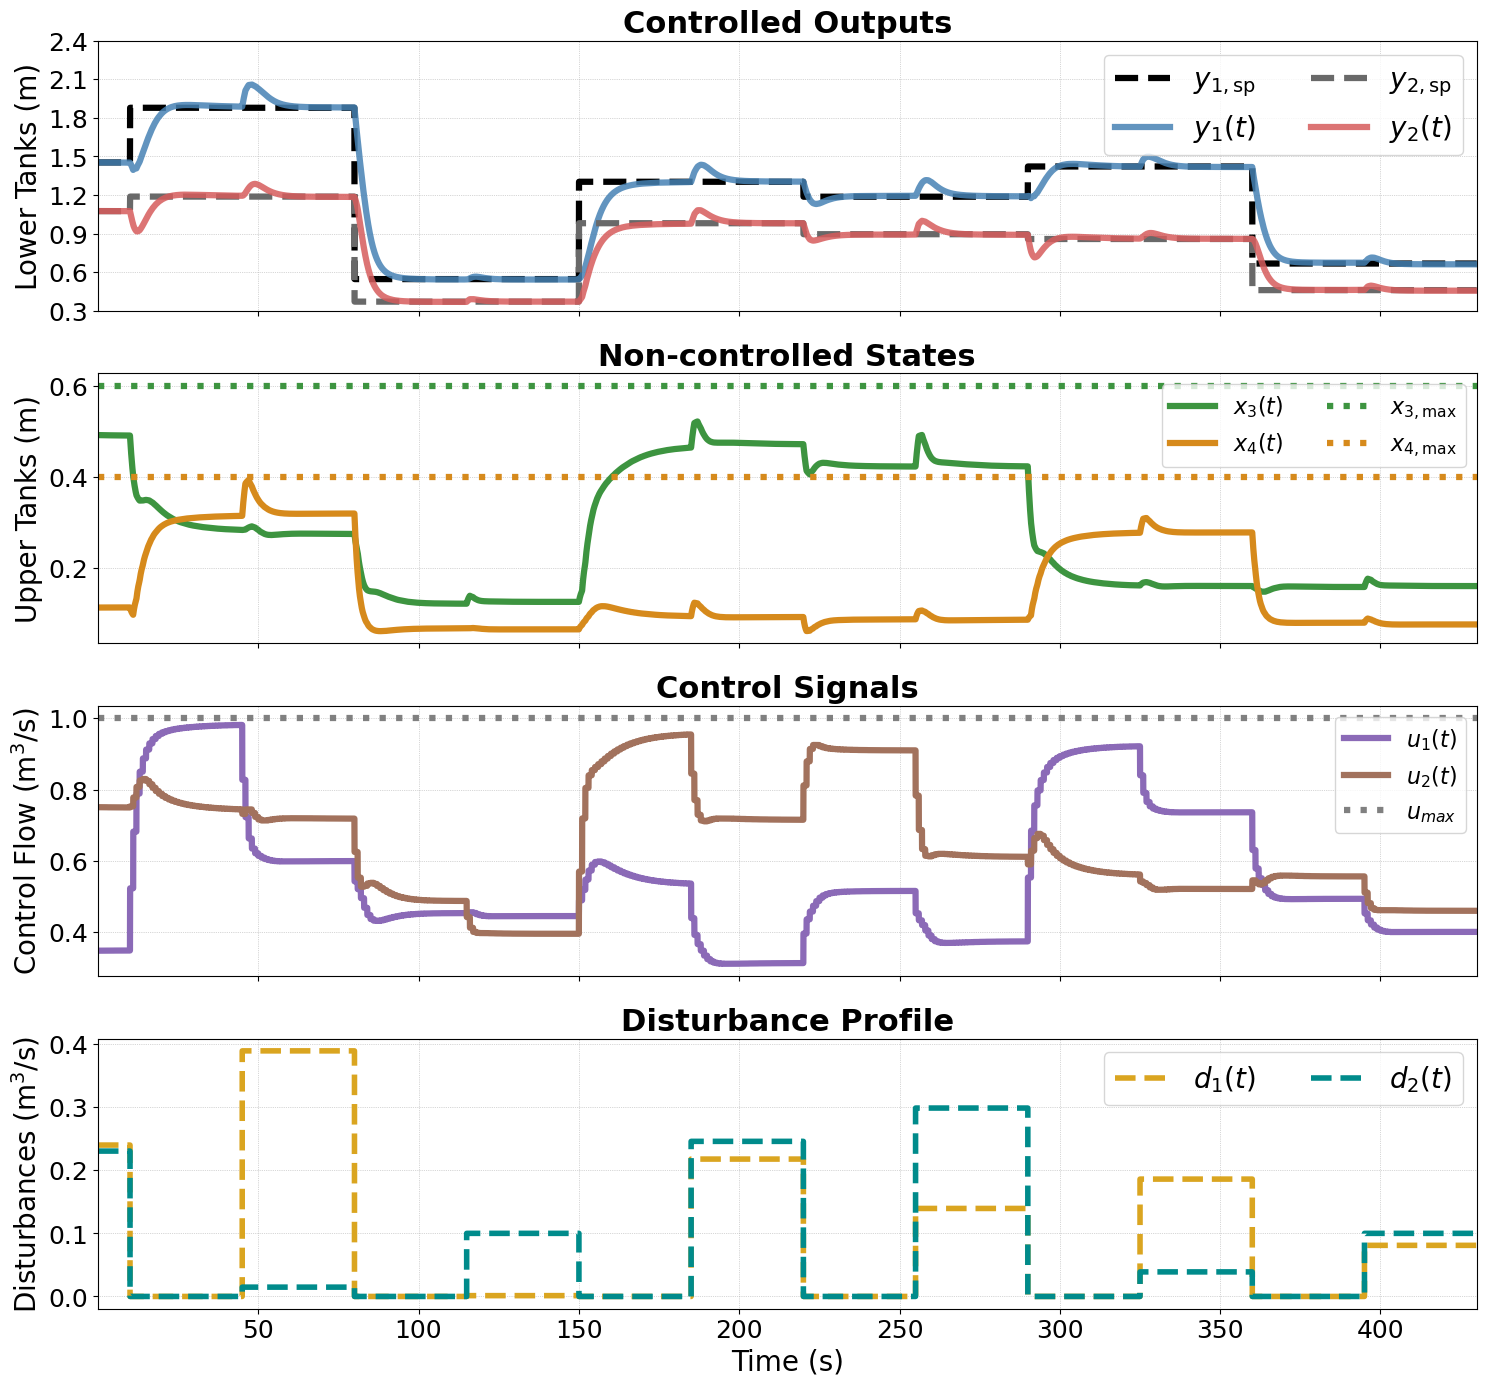

In [ ]:
## ------- RUN CLOSED-LOOP SIMULATIONS WITH DIFFERENT SET-POINT VALUES AND DISTUBANCES ------ ##

# --- Define Test Scenarios ---

# Initial conditions for the *start* of the first episode
x0 = (0.552, 0.470, 0.327, 0.013)
u0 = (0.2, 0.8)

# A list of setpoints. Each item is a new "episode".
ysp_list = [ (1.4533424377441406, 1.0748934745788574),
             (1.8782708644866943, 1.1878788471221924),
             (0.546535074710846, 0.37133535742759705),
             (1.3031206130981445, 0.9808844327926636),
             (1.1869328022003174, 0.8955139517784119),
             (1.4219255447387695, 0.8581873774528503),
             (0.6675326824188232, 0.460819810628891)]

# A corresponding list of disturbances for each episode.
d0_list =  [ (0.2399524450302124, 0.23040156066417694),
             (0.38926956057548523, 0.01474764384329319),
             (0.0012777805095538497, 0.10000000149011612),
             (0.21773341298103333, 0.24582837522029877),
             (0.13947515189647675, 0.298622190952301),
             (0.1859985888004303, 0.038927555084228516),
             (0.08098208904266357, 0.10000000149011612)]

# Run back-to-back scenarios and plot
t_full, x_full, u_full, ysp_full, d_full = evaluate_multi_case(
    model,
    x0=x0,
    u0=u0,
    ysp_list=ysp_list,
    d0_list=d0_list,
    simulation_time=70.0, # Duration *per episode*
    shift_time=60.0,      # Time to cut from the *start* of the final plot
    d_step=35.0,          # Time *within each episode* to apply disturbance
    ylimits_lo=(0.3, 2.4)
)